In [1]:
%%HTML
<style>
body {
  #background-color: #FFFAFA !important;
  border-bottom: solid 10px #F4BD2F !important;
}
</style> 

# 機械学習による分類(Classification)ケーススタディ

 #### 本ケーススタディのステップ

 - Step1 データ内容確認・可視化
 - Step2 データ前処理
 - Step3 モデル構築・検証
 - Step4 最適モデルによる結果確認

#### 今回試行する分類モデル

|モデル|内容|使用ライブラリ|
|:-----:|:--------:|:--------:|
|**決定木**|ツリー状の分岐処理で最も説明力の高いものを採用|[sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)|
|**ランダムフォレスト**|複数の決定木の多数決で分類|[sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)|
|**XGBoost**|勾配ブースティングによる決定木の構築|[xgboost.XGBClassifier](https://github.com/dmlc/xgboost)|
|**k近傍法**|説明変数に最も近い教師データによる分類|[sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)|
|**サポートベクターマシン**|データ分類の境界線をマージンが最小になるように定める手法|[sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
|**多層パーセプトロン**|パーセプトロンを複数つないだ深層学習|[keras.wrappers.scikit_learn.KerasClassifier](https://keras.io/ja/scikit-learn-api/)

### Step1 データ内容確認・可視化

#### 対象データセット：Credit Risk Analytics (book)

 - http://www.creditriskanalytics.net/datasets-private.html
 - 住宅ローンのデフォルト予測
 - 原書籍: H. Scheule, D. Roesch, B. Baesens, Credit Risk Analytics: The R Companion, Scheule Roesch Baesens, 2017.


#### 1-1 データ読込

In [2]:
# 基本的なライブラリをインポート
import numpy as np
import pandas as pd
# 元データ読込
df_raw =  pd.read_csv('https://storage.googleapis.com/creditscore1/hmeq.csv')

#### 1-2 データ分割
 - 本ケーススタディでは全データ(5960件)を、学習用データ（80%, 4768件）と検証用データ(20%, 1192件)に分割して使用します。

In [3]:
#データ分割
from sklearn.model_selection import train_test_split
df_train,  df_test, _, _ = train_test_split(df_raw, df_raw, test_size=0.2, random_state=2018)

#### 1-3 データの全体像を確認（DataFrameクラス関数を使用）

|DataFrameクラス関数|内容|
|:-----:|:--------:|
|**`df.info()`**|行数・列数やメモリ使用量などの情報を表示|
|**`df.head(n)`**|最初のn行を表示|
|**`df.describe()`**|各列の情報を表示|

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 497 to 1274
Data columns (total 13 columns):
BAD        4768 non-null int64
LOAN       4768 non-null int64
MORTDUE    4358 non-null float64
VALUE      4677 non-null float64
REASON     4559 non-null object
JOB        4544 non-null object
YOJ        4358 non-null float64
DEROG      4215 non-null float64
DELINQ     4319 non-null float64
CLAGE      4533 non-null float64
NINQ       4369 non-null float64
CLNO       4599 non-null float64
DEBTINC    3757 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 521.5+ KB


#### 1-4 データ定義を確認 ([著者website](http://www.creditriskanalytics.net/datasets-private.html)より)

|field|content|
|:-----:|:--------:|
|**BAD**|1 = applicant defaulted on loan or seriously delinquent; 0 = applicant paid loan（=**目的変数**）|
|LOAN|Amount of the loan request|
|MORTDUE|Amount due on existing mortgage|
|VALUE|Value of current property|
|REASON|DebtCon = debt consolidation; HomeImp = home improvement|
|JOB|Occupational categories|
|YOJ|Years at present job|
|DEROG|Number of major derogatory reports|
|DELINQ|Number of delinquent credit lines|
|CLAGE|Age of oldest credit line in months|
|NINQ|Number of recent credit inquiries|
|CLNO|Number of credit lines|
|DEBTINC|Debt-to-income ratio|

In [5]:
# 最初のn行を表示
df_train.head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
497,1,7000,25000.0,49840.0,DebtCon,Office,0.6,0.0,0.0,139.000000,0.0,13.0,NaN
5240,0,28400,53480.0,90560.0,DebtCon,Other,24.0,0.0,1.0,174.474724,0.0,19.0,24.490839
1941,0,12700,72164.0,104220.0,DebtCon,Office,10.0,0.0,0.0,165.430782,0.0,13.0,37.539963
567,0,7500,72097.0,69408.0,HomeImp,Sales,4.0,1.0,0.0,155.391962,1.0,23.0,41.600983
513,0,7100,120176.0,180104.0,DebtCon,Other,8.0,0.0,0.0,221.607324,0.0,18.0,32.674359
2659,0,15200,NaN,67103.0,NaN,NaN,1.0,0.0,0.0,NaN,0.0,0.0,3.688958
598,0,7600,58622.0,77726.0,HomeImp,Other,15.0,0.0,0.0,249.633761,2.0,36.0,34.882066
585,1,7500,NaN,71799.0,HomeImp,Mgr,4.0,0.0,3.0,177.500000,0.0,22.0,NaN
4245,0,22100,24000.0,49000.0,DebtCon,Other,14.4,0.0,0.0,109.566667,2.0,25.0,NaN
1736,0,12000,85039.0,111100.0,DebtCon,ProfExe,0.2,1.0,2.0,144.066667,1.0,34.0,NaN


In [6]:
# 各列の情報を表示（特にmin/maxをチェック）
df_train.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,4768.000000,4768.000000,4358.000000,4677.000000,4358.000000,4215.000000,4319.000000,4533.000000,4369.000000,4599.000000,3757.000000
mean,0.198406,18676.174497,73445.724507,101590.795089,8.955863,0.252432,0.448947,180.135836,1.197528,21.290933,33.745125
std,0.398841,11277.823933,44881.663041,57423.329864,7.613783,0.844791,1.122684,86.735052,1.734596,10.102699,8.862992
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,45960.750000,66000.000000,3.000000,0.000000,0.000000,115.193321,0.000000,14.500000,29.055433
50%,0.000000,16400.000000,64806.500000,89061.000000,7.000000,0.000000,0.000000,173.500000,1.000000,20.000000,34.871643
75%,0.000000,23325.000000,91003.000000,119326.000000,13.000000,0.000000,0.000000,230.880154,2.000000,26.000000,39.048428
max,1.000000,89900.000000,399550.000000,855909.000000,36.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


#### 1-5 データ全体像把握の結果
 - 各説明変数にNANあり。本ケーススタディでは簡便な対応（unknown/medianで補完）

In [7]:
# 目的変数定義
name_obj = 'BAD'
# 説明変数分類
names_num = ['LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']
names_ord = []
names_nominal = ['REASON','JOB']
names_all = names_num + names_ord + names_nominal

In [8]:
# num変数はmedianで補完
df_train2_num = df_train[names_num].fillna(df_train[names_num].median())
# nominal変数はunknownで補完
df_train2_nominal = df_train[names_nominal].fillna('Unknown')
df_train2 = pd.concat([df_train[name_obj],df_train2_num,df_train2_nominal], axis=1)

In [9]:
df_train2.head(10)

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
497,1,7000,25000.0,49840.0,0.6,0.0,0.0,139.000000,0.0,13.0,34.871643,DebtCon,Office
5240,0,28400,53480.0,90560.0,24.0,0.0,1.0,174.474724,0.0,19.0,24.490839,DebtCon,Other
1941,0,12700,72164.0,104220.0,10.0,0.0,0.0,165.430782,0.0,13.0,37.539963,DebtCon,Office
567,0,7500,72097.0,69408.0,4.0,1.0,0.0,155.391962,1.0,23.0,41.600983,HomeImp,Sales
513,0,7100,120176.0,180104.0,8.0,0.0,0.0,221.607324,0.0,18.0,32.674359,DebtCon,Other
2659,0,15200,64806.5,67103.0,1.0,0.0,0.0,173.500000,0.0,0.0,3.688958,Unknown,Unknown
598,0,7600,58622.0,77726.0,15.0,0.0,0.0,249.633761,2.0,36.0,34.882066,HomeImp,Other
585,1,7500,64806.5,71799.0,4.0,0.0,3.0,177.500000,0.0,22.0,34.871643,HomeImp,Mgr
4245,0,22100,24000.0,49000.0,14.4,0.0,0.0,109.566667,2.0,25.0,34.871643,DebtCon,Other
1736,0,12000,85039.0,111100.0,0.2,1.0,2.0,144.066667,1.0,34.0,34.871643,DebtCon,ProfExe


#### 1-6 可視化用ライブラリのインポート

In [10]:
# 描画にはmatplotlibとseabornを使用
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
#plt.style.use('ggplot')

# Outcome = 1 のインデックスを取得しておく
idx_1 = df_train[name_obj]==1

#### 1-7 Numerical変数の可視化・検討
 - 各説明変数の分布の可視化（今回は省略）
 - **目的変数との相関関係の可視化**

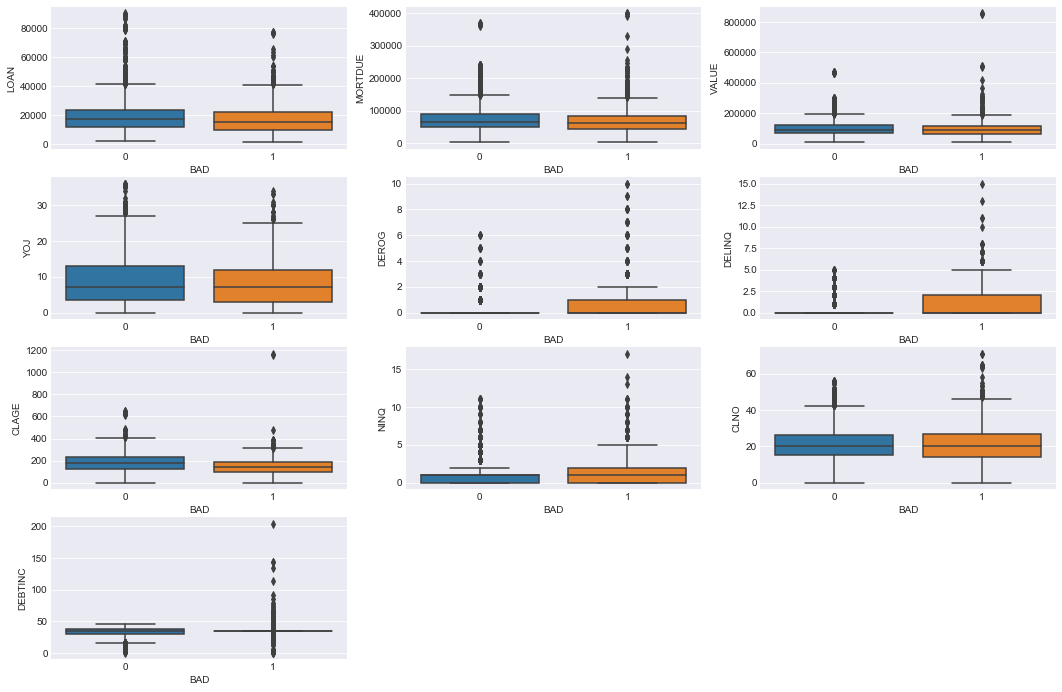

In [11]:
# 目的変数との相関関係の可視化（横軸が目的変数、縦軸が説明変数）
fig = plt.figure(figsize=(18,12))
for i, name in enumerate(names_num):
    ax = fig.add_subplot(4,3,i+1)
    sns.boxplot(data=df_train2, y=name ,x=name_obj, orient='v', ax=ax)

#### 1-8 Categorical変数の可視化・検討
 - 各説明変数の分布の可視化（今回は省略）
 - **目的変数との相関関係の可視化**

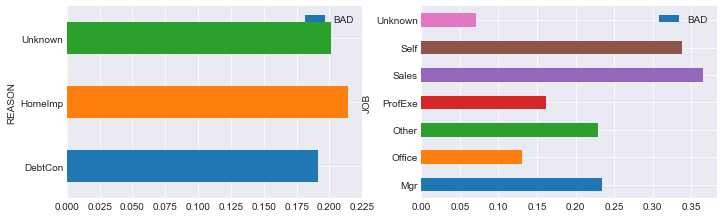

In [12]:
# 目的変数との相関関係の可視化（縦軸が説明変数、横軸がBAD割合）
fig = plt.figure(figsize=(18,12))
for i, name in enumerate(names_ord + names_nominal):
    ax = fig.add_subplot(3,3,i+1)
    df_train2.groupby(name).mean().plot(y=name_obj, kind='barh', ax=ax)

#### データ定義（再掲）

|field|content|
|:-----:|:--------:|
|**BAD**|1 = applicant defaulted on loan or seriously delinquent; 0 = applicant paid loan（=**目的変数**）|
|LOAN|Amount of the loan request|
|MORTDUE|Amount due on existing mortgage|
|VALUE|Value of current property|
|REASON|DebtCon = debt consolidation; HomeImp = home improvement|
|JOB|Occupational categories|
|YOJ|Years at present job|
|DEROG|Number of major derogatory reports|
|DELINQ|Number of delinquent credit lines|
|CLAGE|Age of oldest credit line in months|
|NINQ|Number of recent credit inquiries|
|CLNO|Number of credit lines|
|DEBTINC|Debt-to-income ratio|

### Step2 データ前処理

#### 2-1 データ分割
 - あらためてデータを作成します
 - 学習用データとテストデータに分ける前に、まずX（説明変数）とy（目的変数）に分割します

In [13]:
# 説明変数/目的変数分割 （Step1で識別した欠損値補間を忘れず）
X_num = df_raw[names_num].fillna(df_raw[names_num].median())
X_nominal = df_raw[names_nominal].fillna('Unknown')
X = pd.concat([X_num, X_nominal], axis=1)
y = df_raw[name_obj]

#### 2-2 Numerical変数処理
- 標準化
- 学習用データとテスト用データを別々に処理しないように注意

In [14]:
# names_num処理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X[names_num])
X[names_num]=scaler.transform(X[names_num])

In [15]:
X[names_num].head(10)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,-1.562299,-1.107920,-1.099371,0.240237,-0.280976,-0.375943,-1.018026,-0.102879,-1.230878,0.106963
1,-1.544453,-0.069286,-0.582794,-0.241936,-0.280976,1.477341,-0.689350,-0.707574,-0.728389,0.106963
2,-1.526606,-1.398407,-1.491970,-0.655226,-0.280976,-0.375943,-0.358680,-0.102879,-1.130380,0.106963
3,-1.526606,-0.187596,-0.216389,-0.241936,-0.280976,-0.375943,-0.071488,-0.102879,-0.125403,0.106963
4,-1.508759,0.582831,0.183939,-0.792990,-0.280976,-0.375943,-1.030391,-0.707574,-0.728389,0.106963
5,-1.508759,-0.997741,-1.076598,0.033591,-0.280976,-0.375943,-0.933073,-0.102879,-1.331376,0.407249
6,-1.499836,-0.572327,-0.782619,-0.517463,3.476581,1.477341,-1.224645,-0.102879,-0.426896,0.106963
7,-1.499836,-1.045827,-1.028871,0.309118,-0.280976,-0.375943,-1.085045,-0.707574,-1.331376,0.377327
8,-1.481989,-0.947164,-0.963698,-0.792990,-0.280976,1.477341,0.448650,-0.102879,-0.929385,0.106963
9,-1.481989,-0.187596,-0.690946,0.997936,-0.280976,-0.375943,-0.761547,-0.707574,-0.828887,0.106963


#### 2-3 Categorical-nominal 変数: One-Hot Encoding (OHE)
 - 学習用データとテスト用データを別々に処理しないように注意

In [16]:
# names_nominal処理
df_dummy = pd.get_dummies(X.astype(object)[names_nominal], drop_first=True)
X = pd.merge(X.drop(columns=names_nominal), df_dummy, left_index=True, right_index=True)

#### 出来上がったXはこんな感じ

In [17]:
X.head(10)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,REASON_Unknown,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,JOB_Unknown
0,-1.562299,-1.107920,-1.099371,0.240237,-0.280976,-0.375943,-1.018026,-0.102879,-1.230878,0.106963,1,0,0,1,0,0,0,0
1,-1.544453,-0.069286,-0.582794,-0.241936,-0.280976,1.477341,-0.689350,-0.707574,-0.728389,0.106963,1,0,0,1,0,0,0,0
2,-1.526606,-1.398407,-1.491970,-0.655226,-0.280976,-0.375943,-0.358680,-0.102879,-1.130380,0.106963,1,0,0,1,0,0,0,0
3,-1.526606,-0.187596,-0.216389,-0.241936,-0.280976,-0.375943,-0.071488,-0.102879,-0.125403,0.106963,0,1,0,0,0,0,0,1
4,-1.508759,0.582831,0.183939,-0.792990,-0.280976,-0.375943,-1.030391,-0.707574,-0.728389,0.106963,1,0,1,0,0,0,0,0
5,-1.508759,-0.997741,-1.076598,0.033591,-0.280976,-0.375943,-0.933073,-0.102879,-1.331376,0.407249,1,0,0,1,0,0,0,0
6,-1.499836,-0.572327,-0.782619,-0.517463,3.476581,1.477341,-1.224645,-0.102879,-0.426896,0.106963,1,0,0,1,0,0,0,0
7,-1.499836,-1.045827,-1.028871,0.309118,-0.280976,-0.375943,-1.085045,-0.707574,-1.331376,0.377327,1,0,0,1,0,0,0,0
8,-1.481989,-0.947164,-0.963698,-0.792990,-0.280976,1.477341,0.448650,-0.102879,-0.929385,0.106963,1,0,0,1,0,0,0,0
9,-1.481989,-0.187596,-0.690946,0.997936,-0.280976,-0.375943,-0.761547,-0.707574,-0.828887,0.106963,1,0,0,0,0,1,0,0


#### 2-4 学習用データとテスト用データを分割

In [18]:
# scikit-learnのtrain_test_split関数で学習用データとテスト用データを分割
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

In [19]:
# サイズ確認
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4768, 18)
(1192, 18)
(4768,)
(1192,)


In [20]:
# 内容確認
X_train.head(10)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,REASON_Unknown,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,JOB_Unknown
497,-1.035821,-1.128131,-0.909183,-1.123622,-0.280976,-0.375943,-0.483928,-0.707574,-0.828887,0.106963,0,0,1,0,0,0,0,0
5240,0.873778,-0.458788,-0.193097,2.100044,-0.280976,0.550699,-0.059425,-0.707574,-0.225901,-1.244107,0,0,0,1,0,0,0,0
1941,-0.527189,-0.019672,0.047123,0.171355,-0.280976,-0.375943,-0.167648,-0.707574,-0.828887,0.463025,0,0,1,0,0,0,0,0
567,-0.991204,-0.021247,-0.565068,-0.655226,0.971543,-0.375943,-0.287776,-0.102879,0.176090,0.994302,1,0,0,0,0,1,0,0
513,-1.026898,1.108717,1.381589,-0.104172,-0.280976,-0.375943,0.504580,-0.707574,-0.326398,-0.173510,0,0,0,1,0,0,0,0
2659,-0.304105,-0.187596,-0.605603,-1.068517,-0.280976,-0.375943,-0.071488,-0.707574,-2.135358,-3.965482,0,1,0,0,0,0,0,1
598,-0.982281,-0.337940,-0.418791,0.860173,-0.280976,-0.375943,0.839954,0.501815,1.482561,0.115310,1,0,0,1,0,0,0,0
585,-0.991204,-0.187596,-0.523021,-0.655226,-0.280976,2.403983,-0.023223,-0.707574,0.075593,0.106963,1,0,0,0,0,0,0,0
4245,0.311606,-1.151634,-0.923955,0.777515,-0.280976,-0.375943,-0.836137,0.501815,0.377086,0.106963,0,0,0,1,0,0,0,0
1736,-0.589653,0.282919,0.168112,-1.178728,0.971543,1.477341,-0.423298,-0.102879,1.281565,0.106963,0,0,0,0,1,0,0,0


### Step3 予測モデル構築

#### 今回試行する分類モデル（再掲）

|モデル|内容|使用ライブラリ|
|:-----:|:--------:|:--------:|
|**決定木**|ツリー状の分岐処理で最も説明力の高いものを採用|[sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)|
|**ランダムフォレスト**|複数の決定木の多数決で分類|[sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)|
|**XGBoost**|勾配ブースティングによる決定木の構築|[xgboost.XGBClassifier](https://github.com/dmlc/xgboost)|
|**k近傍法**|説明変数に最も近い教師データによる分類|[sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)|
|**サポートベクターマシン**|データ分類の境界線をマージンが最小になるように定める手法|[sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
|**多層パーセプトロン**|パーセプトロンを複数つないだ深層学習|[keras.wrappers.scikit_learn.KerasClassifier](https://keras.io/ja/scikit-learn-api/)

In [21]:
# 使うライブラリを一通りimport
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

/Applications/anaconda3/envs/flask/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 3-0 モデル構築・検証方針
 - 学習用データを3分割する3分割交差検証の方法を使用
 - 交差検証結果が最良のモデルにつき、テストデータに適用して妥当性を確認

In [22]:
# 3分割交差検証の分割 (sklearn.model_selection_StratifiedKFold())
skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
# 結果格納用リスト
list_result = []

In [23]:
#　分類特有の評価関数・プロット(ROC)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

#### 3-1 決定木

In [24]:
# 試行パラメータ
param_grid = {'max_depth': [1,3,5,10]}
# グリッドサーチ実行
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['DecisionTree', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

Grid scores on development set:
0.804 (+/-0.003) for {'max_depth': 1}
0.856 (+/-0.007) for {'max_depth': 3}
0.886 (+/-0.004) for {'max_depth': 5}
0.880 (+/-0.009) for {'max_depth': 10}
Best parameters: {'max_depth': 5}
Best cross-validation: 0.8859060402684564


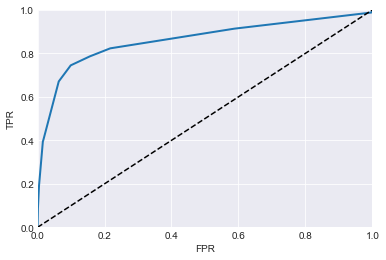

0.8610493176703221

In [25]:
# ROC曲線
resultprob = pd.DataFrame(grid_search.best_estimator_.predict_proba(X_test))
fpr, tpr, thresholds = roc_curve(y_test, resultprob.iloc[:,1])
plot_roc_curve(fpr, tpr)    
plt.show()
roc_auc_score(y_test, resultprob.iloc[:,1])

#### 3-2 ランダムフォレスト


In [26]:
# 試行パラメータ
param_grid = {'n_estimators': [10,20,100]}
# グリッドサーチ実行
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['RandomForest', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

Grid scores on development set:
0.902 (+/-0.007) for {'n_estimators': 10}
0.911 (+/-0.004) for {'n_estimators': 20}
0.913 (+/-0.005) for {'n_estimators': 100}
Best parameters: {'n_estimators': 100}
Best cross-validation: 0.912751677852349


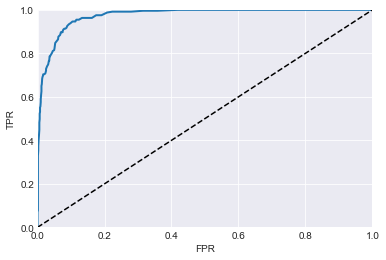

0.9740337457232434

In [27]:
# ROC曲線
resultprob = pd.DataFrame(grid_search.best_estimator_.predict_proba(X_test))
fpr, tpr, thresholds = roc_curve(y_test, resultprob.iloc[:,1])
plot_roc_curve(fpr, tpr)    
plt.show()
roc_auc_score(y_test, resultprob.iloc[:,1])

#### 3-4 K近傍法


In [28]:
# 試行パラメータ
param_grid = {'n_neighbors': [1,2,3]}
# グリッドサーチ実行
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['KNeighbors', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

Grid scores on development set:
0.930 (+/-0.007) for {'n_neighbors': 1}
0.892 (+/-0.005) for {'n_neighbors': 2}
0.906 (+/-0.004) for {'n_neighbors': 3}
Best parameters: {'n_neighbors': 1}
Best cross-validation: 0.9299496644295302


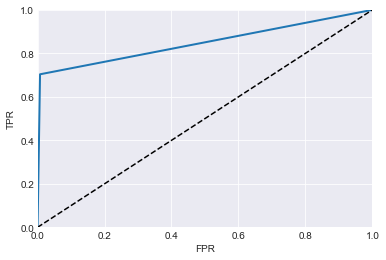

0.8481637591226632

In [29]:
# ROC曲線
resultprob = pd.DataFrame(grid_search.best_estimator_.predict_proba(X_test))
fpr, tpr, thresholds = roc_curve(y_test, resultprob.iloc[:,1])
plot_roc_curve(fpr, tpr)    
plt.show()
roc_auc_score(y_test, resultprob.iloc[:,1])

#### 3-5 Support Vector Machine (SVM)


In [30]:
# 試行パラメータ
param_grid = {'C': [0.1,1,10]}
# グリッドサーチ実行
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['SVM', mean_test_score,  std_test_score, params])    
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

Grid scores on development set:
0.828 (+/-0.003) for {'C': 0.1}
0.857 (+/-0.007) for {'C': 1}
0.895 (+/-0.005) for {'C': 10}
Best parameters: {'C': 10}
Best cross-validation: 0.8951342281879194


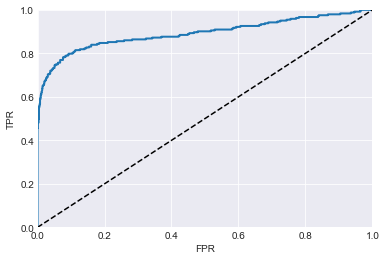

0.8918744877648987

In [31]:
# ROC曲線
resultprob = pd.DataFrame(grid_search.best_estimator_.predict_proba(X_test))
fpr, tpr, thresholds = roc_curve(y_test, resultprob.iloc[:,1])
plot_roc_curve(fpr, tpr)    
plt.show()
roc_auc_score(y_test, resultprob.iloc[:,1])

#### 3-6 MLP


In [32]:
# Kerasのモデルを構築
def create_MLP():
    model = Sequential()
    model.add(Dense(10, input_dim=18, activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model
# scikit-learn wrapper
clf = KerasClassifier(build_fn=create_MLP, verbose=1)

In [33]:
# 試行パラメータ
param_grid = {}
# グリッドサーチ実行
grid_search = GridSearchCV(clf, param_grid, cv=skf)
grid_search.fit(X_train, y_train)
# 結果確認
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean_test_score, std_test_score, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_test_score,  std_test_score, params))
    list_result.append(['MLP', mean_test_score,  std_test_score, params])
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

Epoch 1/1
3178/3178 [==============================] - 0s 17us/step
Epoch 1/1
3179/3179 [==============================] - 0s 18us/step
Epoch 1/1
3179/3179 [==============================] - 0s 15us/step
Epoch 1/1
4768/4768 [==============================] - 1s 125us/step - loss: 0.5372 - acc: 0.7366
Grid scores on development set:
0.821 (+/-0.001) for {}
Best parameters: {}
Best cross-validation: 0.8213087248072128


1192/1192 [==============================] - 0s 67us/step


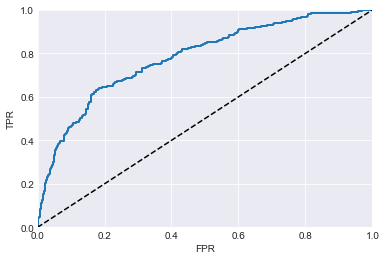

0.7812078557892865

In [34]:
# ROC曲線
resultprob = pd.DataFrame(grid_search.best_estimator_.predict_proba(X_test))
fpr, tpr, thresholds = roc_curve(y_test, resultprob.iloc[:,1])
plot_roc_curve(fpr, tpr)    
plt.show()
roc_auc_score(y_test, resultprob.iloc[:,1])

#### 3-7 モデル選択
結果を並べてみましょう

In [35]:
for result in list_result:
    print(result)

['DecisionTree', 0.8041107382550335, 0.003320410867180292, {'max_depth': 1}]
['DecisionTree', 0.8559144295302014, 0.007426500520040189, {'max_depth': 3}]
['DecisionTree', 0.8859060402684564, 0.004092446934825674, {'max_depth': 5}]
['DecisionTree', 0.8802432885906041, 0.009033803710733916, {'max_depth': 10}]
['RandomForest', 0.9024748322147651, 0.006919732267767665, {'n_estimators': 10}]
['RandomForest', 0.9110738255033557, 0.0043706989943999635, {'n_estimators': 20}]
['RandomForest', 0.912751677852349, 0.00479192078045576, {'n_estimators': 100}]
['KNeighbors', 0.9299496644295302, 0.0073485298210048434, {'n_neighbors': 1}]
['KNeighbors', 0.8921979865771812, 0.005049918767709501, {'n_neighbors': 2}]
['KNeighbors', 0.90625, 0.004462262244631824, {'n_neighbors': 3}]
['SVM', 0.8284395973154363, 0.0034626335432210885, {'C': 0.1}]
['SVM', 0.8573825503355704, 0.006591152995635182, {'C': 1}]
['SVM', 0.8951342281879194, 0.004781670992200678, {'C': 10}]
['MLP', 0.8213087248072128, 0.0013945010065

今回の最適モデルはKNeighbors (n_neighbors=1)

### Step4 最適モデルによる予測

In [36]:
# 最適モデル構築
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
# 最適モデルによるテストデータ予測
result = pd.DataFrame(clf.predict(X_test), columns=['result'])

In [37]:
# テストデータ予測結果を結合
results = pd.concat([df_test.reset_index(drop=True),result],axis=1)
results.head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,result
0,0,11400,112930.0,144830.0,DebtCon,ProfExe,2.0,0.0,0.0,271.238037,1.0,46.0,33.251079,0
1,0,8700,77930.0,80164.0,HomeImp,Other,20.0,0.0,0.0,350.528410,1.0,47.0,29.662360,0
2,0,9300,54088.0,66961.0,DebtCon,Other,22.0,0.0,0.0,278.160473,3.0,28.0,40.823542,0
3,0,18600,49385.0,70220.0,DebtCon,ProfExe,6.0,0.0,0.0,229.474919,2.0,32.0,30.731397,0
4,0,38100,33446.0,73289.0,DebtCon,ProfExe,5.0,0.0,0.0,180.847815,1.0,18.0,23.820415,0
5,0,12800,77318.0,97616.0,DebtCon,Mgr,6.0,0.0,0.0,125.534802,2.0,27.0,39.462663,0
6,0,28200,148772.0,186023.0,HomeImp,Self,3.0,0.0,0.0,203.575860,1.0,17.0,43.304658,0
7,0,18300,93728.0,153093.0,HomeImp,ProfExe,5.0,0.0,0.0,109.337106,0.0,16.0,36.213987,0
8,1,5000,40000.0,32480.0,HomeImp,Other,8.0,3.0,2.0,163.366667,1.0,16.0,NaN,1
9,1,23000,56000.0,92000.0,DebtCon,Other,8.0,1.0,4.0,69.133333,2.0,27.0,NaN,1


#### テストデータ予測結果の可視化

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Classification Report
print(classification_report(results['result'],results['BAD']))
# Confusion Matrix
print(confusion_matrix(results['result'],results['BAD']))

             precision    recall  f1-score   support

          0       0.99      0.93      0.96      1014
          1       0.70      0.96      0.81       178

avg / total       0.95      0.93      0.94      1192

[[942  72]
 [  7 171]]
